# Deep Learning and Computer Chess

In [177]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import chess
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import os

In [178]:
df = pd.read_csv('../output/evaluations.csv')
df.head()

,FEN,Evaluation,Category
0,r3k3/p4n1p/3p1Bq1/3P4/2p2P2/7P/P3Q1P1/5R1K b q...,5.2,White is winning
1,r3k3/p4n1p/3p1Bq1/3P4/2p2P2/7P/P3Q1P1/5R1K b q...,5.2,White is winning
2,4Q3/7k/2p4p/1p1qP1p1/3B1nR1/2P4P/3r2P1/6K1 w -...,0.0,Even
3,4Q3/7k/2p4p/1p1qP1p1/3B1nR1/2P4P/3r2P1/6K1 w -...,0.0,Even
4,2k4r/ppp2p2/2b2B2/7p/6pP/2P4P/PP3Nq1/R5K1 w - ...,0.0,Even


In [179]:
df.shape

(76916, 3)

In [180]:
df.isnull().sum()

FEN           0
Evaluation    0
Category      0
dtype: int64

In [181]:
df.rename(columns={'FEN': 'fen', 'Evaluation': 'evaluation', 'Category': 'category'}, inplace=True)
df.head()

,fen,evaluation,category
0,r3k3/p4n1p/3p1Bq1/3P4/2p2P2/7P/P3Q1P1/5R1K b q...,5.2,White is winning
1,r3k3/p4n1p/3p1Bq1/3P4/2p2P2/7P/P3Q1P1/5R1K b q...,5.2,White is winning
2,4Q3/7k/2p4p/1p1qP1p1/3B1nR1/2P4P/3r2P1/6K1 w -...,0.0,Even
3,4Q3/7k/2p4p/1p1qP1p1/3B1nR1/2P4P/3r2P1/6K1 w -...,0.0,Even
4,2k4r/ppp2p2/2b2B2/7p/6pP/2P4P/PP3Nq1/R5K1 w - ...,0.0,Even


In [182]:
def king_safety_vector(board, king_color):
    king_square = board.king(king_color)

    # King File Openness
    king_file = chess.square_file(king_square)
    king_file_open = 1 if all(board.piece_at(chess.square(king_file, rank)) is None for rank in range(8)) else 0

    # Pawn Shield
    pawn_shield = [
        1 if board.piece_at(chess.square(king_file + offset, 1 if king_color == chess.WHITE else 6)) and 
        board.piece_at(chess.square(king_file + offset, 1 if king_color == chess.WHITE else 6)).symbol().lower() == 'p' else 0 
        for offset in [-1, 0, 1] if 0 <= king_file + offset < 8
    ]
    while len(pawn_shield) < 3:
        pawn_shield.append(0)

    # Castling Status
    castling_rights = [
        1 if board.has_kingside_castling_rights(king_color) else 0,
        1 if board.has_queenside_castling_rights(king_color) else 0,
    ]

    # Enemy Pieces Attacking King
    enemy_color = chess.BLACK if king_color == chess.WHITE else chess.WHITE
    # king_attackers = len(board.attackers(enemy_color, king_square))

    # King Centralization
    king_centralization = 1 if king_file in [2, 3, 4, 5] else 0

    # King Escape Squares


    # Piece Blocking Check
    if board.is_check():
    # Find all possible blocking squares (between attacker and king)
        attack_moves = [
            move for move in board.legal_moves
            if move.to_square in chess.SquareSet.between(board.king(board.turn), board.king(not board.turn))
        ]
        can_block_check = 1 if attack_moves else 0
    else:
        can_block_check = 0


    # King Mobility
    # king_mobility = min(len(list(board.legal_moves)), 5)

    # Opposing Queen Presence
    queen_presence = 1 if any(piece.piece_type == chess.QUEEN and piece.color == enemy_color for piece in board.piece_map().values()) else 0

    king_safety_vector = [
        king_file_open,
        *pawn_shield,
        *castling_rights,
        king_centralization,
        can_block_check,
        queen_presence
    ]

    return king_safety_vector

In [183]:
def king_safety(fen):
    board = chess.Board(fen)
    
    white_king_vector = king_safety_vector(board, chess.WHITE)
    black_king_vector = king_safety_vector(board, chess.BLACK)

    return white_king_vector + black_king_vector

In [184]:
def material(fen):
    board = chess.Board(fen)

    piece_types = [chess.PAWN, chess.KNIGHT, chess.BISHOP, chess.ROOK, chess.QUEEN, chess.KING]

    white_pieces = [len(board.pieces(piece, chess.WHITE)) for piece in piece_types]
    black_pieces = [len(board.pieces(piece, chess.BLACK)) for piece in piece_types]

    material_vector = np.array(white_pieces + black_pieces, dtype=np.float32)

    return material_vector

In [185]:
def space(fen):
    board = chess.Board(fen)

    white_space, black_space = 0, 0

    white_pawns = board.pieces(chess.PAWN, chess.WHITE)
    black_pawns = board.pieces(chess.PAWN, chess.BLACK)

    for square in white_pawns:
        rank = chess.square_rank(square)
        if rank >= 4:
            white_space += 1

    for square in black_pawns:
        rank = chess.square_rank(square)
        if rank <= 3:
            black_space += 1

    white_mobility = len(list(board.legal_moves)) if board.turn == chess.WHITE else 0
    black_mobility = len(list(board.legal_moves)) if board.turn == chess.BLACK else 0

    total_white_space = white_space + white_mobility
    total_black_space = black_space + black_mobility

    return [total_white_space, total_black_space]

In [186]:
def pawn_structure(fen):
    board = chess.Board(fen)

    def count_isolated_pawns(pawns):
        isolated_pawns = 0
        for file in range(8):
            if pawns & chess.BB_FILES[file]:
                left_file = file - 1
                right_file = file + 1
                if (left_file >= 0 and pawns & chess.BB_FILES[left_file]) or (right_file <= 7 and pawns & chess.BB_FILES[right_file]):
                    continue
                isolated_pawns += 1

        return isolated_pawns
    
    def count_doubled_pawns(pawns):
        doubled_pawns = 0

        for file in range(8):
            file_pawns = pawns & chess.BB_FILES[file]
            pawn_ranks = [chess.square_rank(square) for square in chess.SquareSet(file_pawns)]

            pawn_ranks.sort()

            for i in range(len(pawn_ranks) - 1):
                if pawn_ranks[i] + 1 == pawn_ranks[i + 1]:
                    doubled_pawns += 1
                    break

        return doubled_pawns
    
    def count_backward_pawns(pawns, color):
        backward_pawns = 0

        for file in range(8):
            file_mask = chess.BB_FILES[file]
            pawns_in_file = pawns & file_mask

            if pawns_in_file:
                forward_pawn = file_mask >> 8 if color == chess.WHITE else file_mask << 8

                left_file = file - 1 if file > 0 else None
                right_file = file + 1 if file < 7 else None

                left_pawns = pawns & chess.BB_FILES[left_file] if left_file is not None else 0
                right_pawns = pawns & chess.BB_FILES[right_file] if right_file is not None else 0

                if not forward_pawn and ((left_pawns & left_pawns >> 8 if color == chess.WHITE else left_pawns << 8) or (right_pawns & right_pawns >> 8 if color == chess.WHITE else right_pawns << 8)):
                    backward_pawns += 1
        
        return backward_pawns

    def count_passed_pawns(pawns, enemy_pawns):
        passed_pawns = 0

        for file in range(8):
            if pawns & chess.BB_FILES[file]:
                front_mask = enemy_pawns & chess.BB_FILES[file]
                if not front_mask:
                    passed_pawns += 1
        
        return passed_pawns

    def count_pawn_islands(pawns):
        pawn_islands = 0
        prev_file_pawn_ranks = set()

        for file in range(8):
            file_pawns = pawns & chess.BB_FILES[file]
            pawn_ranks = sorted([chess.square_rank(square) for square in chess.SquareSet(file_pawns)])

            if not pawn_ranks:
                prev_file_pawn_ranks = set()
                continue

            rank_islands = 1
            for i in range(len(pawn_ranks) - 1):
                if pawn_ranks[i + 1] > pawn_ranks[i] + 1:
                    rank_islands += 1

            if prev_file_pawn_ranks:
                connected = False
                for rank in pawn_ranks:
                    for prev_rank in prev_file_pawn_ranks:
                        if abs(rank - prev_rank) <= 1:
                            connected = True
                            break
                    if connected:
                        break

                if connected:
                    rank_islands -= 1

            pawn_islands += rank_islands
            prev_file_pawn_ranks = set(pawn_ranks)

        return pawn_islands

    white_pawns = board.pieces(chess.PAWN, chess.WHITE)
    black_pawns = board.pieces(chess.PAWN, chess.BLACK)

    white_enemy_pawns = black_pawns
    black_enemy_pawns = white_pawns

    features = [
        count_isolated_pawns(white_pawns),
        count_doubled_pawns(white_pawns),
        count_backward_pawns(white_pawns, chess.WHITE),
        count_passed_pawns(white_pawns, white_enemy_pawns),
        count_pawn_islands(white_pawns),
        count_isolated_pawns(black_pawns),
        count_doubled_pawns(black_pawns),
        count_backward_pawns(black_pawns, chess.BLACK),
        count_passed_pawns(black_pawns, black_enemy_pawns),
        count_pawn_islands(black_pawns)
    ]

    return features

In [187]:
def development(fen):
    board = chess.Board(fen)

    development_vector = []

    minor_pieces = {
        "Knight1_W": chess.B1,
        "Knight2_W": chess.G1,
        "Bishop1_W": chess.C1,
        "Bishop2_W": chess.F1,
        "Knight1_B": chess.B8,
        "Knight2_B": chess.G8,
        "Bishop1_B": chess.C8,
        "Bishop2_B": chess.F8
    }

    for piece_name, start_square in minor_pieces.items():
        piece_type = chess.KNIGHT if "Knight" in piece_name else chess.BISHOP
        color = chess.WHITE if "_W" in piece_name else chess.BLACK
        piece_moved = 1 if board.piece_at(start_square) is None or board.piece_at(start_square).color != color else 0
        development_vector.append(piece_moved)

    center_squares = [chess.D4, chess.E4, chess.D5, chess.E5]
    white_center_control = sum(1 for square in center_squares if board.piece_at(square) is not None and board.piece_at(square).color == chess.WHITE)
    black_center_control = sum(1 for square in center_squares if board.piece_at(square) is not None and board.piece_at(square).color == chess.BLACK)
    development_vector.append(white_center_control)
    development_vector.append(black_center_control)

    return development_vector


In [188]:
def fen_to_bitstring(fen):
    board = chess.Board(fen)

    piece_types = {
        'P': 0,
        'N': 1,
        'B': 2,
        'R': 3,
        'Q': 4,
        'K': 5,
        'p': 6,
        'n': 7,
        'b': 8,
        'r': 9,
        'q': 10,
        'k': 11
    }

    bitboard = np.zeros(768, dtype=int)

    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            piece_index = piece_types[piece.symbol()]
            bitboard[square * 12 + piece_index] = 1

    # Side to move
    side_to_move = 1 if board.turn == chess.WHITE else 0

    # Castling rights
    castling_rights = [
        1 if board.has_kingside_castling_rights(chess.WHITE) else 0,
        1 if board.has_queenside_castling_rights(chess.WHITE) else 0,
        1 if board.has_kingside_castling_rights(chess.BLACK) else 0,
        1 if board.has_queenside_castling_rights(chess.BLACK) else 0
    ]

    # Combine everything into a 773-bit string
    bitstring = np.concatenate((bitboard, [side_to_move] + castling_rights))

    return bitstring

In [189]:
df['bitstring'] = df['fen'].apply(lambda x: fen_to_bitstring(x))
df['king_safety'] = df['fen'].apply(lambda x: king_safety(x))
df['material'] = df['fen'].apply(lambda x: material(x))
df['space'] = df['fen'].apply(lambda x: space(x))
df['pawn_structure'] = df['fen'].apply(lambda x: pawn_structure(x))
df['development'] = df['fen'].apply(lambda x: development(x))
df.head()

,fen,evaluation,category,bitstring,king_safety,material,space,pawn_structure,development
0,r3k3/p4n1p/3p1Bq1/3P4/2p2P2/7P/P3Q1P1/5R1K b q...,5.2,White is winning,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...","[5.0, 0.0, 1.0, 1.0, 1.0, 1.0, 4.0, 1.0, 0.0, ...","[1, 5]","[2, 0, 0, 2, 4, 2, 0, 0, 1, 4]","[1, 1, 1, 0, 1, 1, 1, 1, 1, 0]"
1,r3k3/p4n1p/3p1Bq1/3P4/2p2P2/7P/P3Q1P1/5R1K b q...,5.2,White is winning,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...","[5.0, 0.0, 1.0, 1.0, 1.0, 1.0, 4.0, 1.0, 0.0, ...","[1, 5]","[2, 0, 0, 2, 4, 2, 0, 0, 1, 4]","[1, 1, 1, 0, 1, 1, 1, 1, 1, 0]"
2,4Q3/7k/2p4p/1p1qP1p1/3B1nR1/2P4P/3r2P1/6K1 w -...,0.0,Even,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[4.0, 0.0, 1.0, 1.0, 1.0, 1.0, 4.0, 1.0, 0.0, ...","[31, 0]","[2, 0, 0, 1, 3, 0, 0, 0, 1, 2]","[1, 0, 1, 1, 1, 1, 1, 1, 2, 1]"
3,4Q3/7k/2p4p/1p1qP1p1/3B1nR1/2P4P/3r2P1/6K1 w -...,0.0,Even,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[4.0, 0.0, 1.0, 1.0, 1.0, 1.0, 4.0, 1.0, 0.0, ...","[31, 0]","[2, 0, 0, 1, 3, 0, 0, 0, 1, 2]","[1, 0, 1, 1, 1, 1, 1, 1, 2, 1]"
4,2k4r/ppp2p2/2b2B2/7p/6pP/2P4P/PP3Nq1/R5K1 w - ...,0.0,Even,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, ...","[5.0, 1.0, 1.0, 1.0, 0.0, 1.0, 6.0, 0.0, 1.0, ...","[0, 1]","[1, 1, 0, 0, 2, 0, 0, 0, 2, 3]","[1, 0, 1, 1, 1, 1, 0, 1, 0, 0]"


In [190]:
print(df['bitstring'][0].shape)
print(df['king_safety'][0])
print(df['material'][0])
print(df['space'][0])
print(df['pawn_structure'][0])
print(df['development'][0])

(773,)
[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1]
[5. 0. 1. 1. 1. 1. 4. 1. 0. 1. 1. 1.]
[1, 5]
[2, 0, 0, 2, 4, 2, 0, 0, 1, 4]
[1, 1, 1, 0, 1, 1, 1, 1, 1, 0]


In [191]:
scaler = MinMaxScaler()
df['normalized_material'] = df['material'].apply(lambda x: scaler.fit_transform(np.array(x).reshape(-1, 1)).flatten())
df['normalized_space'] = df['space'].apply(lambda x: scaler.fit_transform(np.array(x).reshape(-1, 1)).flatten())
df['normalized_pawn_structure'] = df['pawn_structure'].apply(lambda x: scaler.fit_transform(np.array(x).reshape(-1, 1)).flatten())

df.head()

,fen,evaluation,category,bitstring,king_safety,material,space,pawn_structure,development,normalized_material,normalized_space,normalized_pawn_structure
0,r3k3/p4n1p/3p1Bq1/3P4/2p2P2/7P/P3Q1P1/5R1K b q...,5.2,White is winning,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...","[5.0, 0.0, 1.0, 1.0, 1.0, 1.0, 4.0, 1.0, 0.0, ...","[1, 5]","[2, 0, 0, 2, 4, 2, 0, 0, 1, 4]","[1, 1, 1, 0, 1, 1, 1, 1, 1, 0]","[1.0, 0.0, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.0, ...","[0.0, 1.0]","[0.5, 0.0, 0.0, 0.5, 1.0, 0.5, 0.0, 0.0, 0.25,..."
1,r3k3/p4n1p/3p1Bq1/3P4/2p2P2/7P/P3Q1P1/5R1K b q...,5.2,White is winning,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...","[5.0, 0.0, 1.0, 1.0, 1.0, 1.0, 4.0, 1.0, 0.0, ...","[1, 5]","[2, 0, 0, 2, 4, 2, 0, 0, 1, 4]","[1, 1, 1, 0, 1, 1, 1, 1, 1, 0]","[1.0, 0.0, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.0, ...","[0.0, 1.0]","[0.5, 0.0, 0.0, 0.5, 1.0, 0.5, 0.0, 0.0, 0.25,..."
2,4Q3/7k/2p4p/1p1qP1p1/3B1nR1/2P4P/3r2P1/6K1 w -...,0.0,Even,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[4.0, 0.0, 1.0, 1.0, 1.0, 1.0, 4.0, 1.0, 0.0, ...","[31, 0]","[2, 0, 0, 1, 3, 0, 0, 0, 1, 2]","[1, 0, 1, 1, 1, 1, 1, 1, 2, 1]","[1.0, 0.0, 0.25, 0.25, 0.25, 0.25, 1.0, 0.25, ...","[1.0, 0.0]","[0.6666666666666666, 0.0, 0.0, 0.3333333333333..."
3,4Q3/7k/2p4p/1p1qP1p1/3B1nR1/2P4P/3r2P1/6K1 w -...,0.0,Even,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[4.0, 0.0, 1.0, 1.0, 1.0, 1.0, 4.0, 1.0, 0.0, ...","[31, 0]","[2, 0, 0, 1, 3, 0, 0, 0, 1, 2]","[1, 0, 1, 1, 1, 1, 1, 1, 2, 1]","[1.0, 0.0, 0.25, 0.25, 0.25, 0.25, 1.0, 0.25, ...","[1.0, 0.0]","[0.6666666666666666, 0.0, 0.0, 0.3333333333333..."
4,2k4r/ppp2p2/2b2B2/7p/6pP/2P4P/PP3Nq1/R5K1 w - ...,0.0,Even,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, ...","[5.0, 1.0, 1.0, 1.0, 0.0, 1.0, 6.0, 0.0, 1.0, ...","[0, 1]","[1, 1, 0, 0, 2, 0, 0, 0, 2, 3]","[1, 0, 1, 1, 1, 1, 0, 1, 0, 0]","[0.8333334, 0.16666667, 0.16666667, 0.16666667...","[0.0, 1.0]","[0.3333333333333333, 0.3333333333333333, 0.0, ..."


In [192]:
print(df['bitstring'][0].shape)
print(df['king_safety'][0])
print(df['normalized_material'][0])
print(df['normalized_space'][0])
print(df['normalized_pawn_structure'][0])
print(df['development'][0])

(773,)
[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1]
[1.  0.  0.2 0.2 0.2 0.2 0.8 0.2 0.  0.2 0.2 0.2]
[0. 1.]
[0.5  0.   0.   0.5  1.   0.5  0.   0.   0.25 1.  ]
[1, 1, 1, 0, 1, 1, 1, 1, 1, 0]


In [ ]:
df['king_safety'] = df['king_safety'].apply(lambda x: np.array(x))
df['normalized_material'] = df['normalized_material'].apply(lambda x: np.array(x))
df['normalized_space'] = df['normalized_space'].apply(lambda x: np.array(x))
df['normalized_pawn_structure'] = df['normalized_pawn_structure'].apply(lambda x: np.array(x))
df['development'] = df['development'].apply(lambda x: np.array(x))

df['vector'] = df.apply(lambda row: np.concatenate([
    row['king_safety'],
    row['normalized_material'],
    row['normalized_space'],
    row['normalized_pawn_structure'],
    row['development']
]), axis=1)

df['global'] = df.apply(lambda row: np.concatenate([
    row['normalized_material'],
    row['normalized_space'],
    row['development']
]), axis=1)

df['piece'] = df.apply(lambda row: np.concatenate([
    row['king_safety'],
    row['normalized_pawn_structure']
]), axis=1)

In [ ]:
df['bitstring_tensor'] = df['bitstring'].apply(lambda x: torch.tensor([bit for bit in x], dtype=torch.float32))
df['king_safety_tensor'] = df['king_safety'].apply(lambda x: torch.tensor([bit for bit in x], dtype=torch.float32))
df['material_tensor'] = df['normalized_material'].apply(lambda x: torch.tensor([bit for bit in x], dtype=torch.float32))
df['space_tensor'] = df['normalized_space'].apply(lambda x: torch.tensor([bit for bit in x], dtype=torch.float32))
df['pawn_structure_tensor'] = df['normalized_pawn_structure'].apply(lambda x: torch.tensor([bit for bit in x], dtype=torch.float32))
df['development_tensor'] = df['development'].apply(lambda x: torch.tensor([bit for bit in x], dtype=torch.float32))
df['vector_tensor'] = df['vector'].apply(lambda x: torch.tensor([bit for bit in x], dtype=torch.float32))
df['global_tensor'] = df['global'].apply(lambda x: torch.tensor([bit for bit in x], dtype=torch.float32))
df['piece_tensor'] = df['piece'].apply(lambda x: torch.tensor([bit for bit in x], dtype=torch.float32))
df.head()

,fen,evaluation,category,bitstring,king_safety,material,space,pawn_structure,development,normalized_material,...,piece,bitstring_tensor,king_safety_tensor,material_tensor,space_tensor,pawn_structure_tensor,development_tensor,vector_tensor,global_tensor,piece_tensor
0,r3k3/p4n1p/3p1Bq1/3P4/2p2P2/7P/P3Q1P1/5R1K b q...,5.2,White is winning,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...","[5.0, 0.0, 1.0, 1.0, 1.0, 1.0, 4.0, 1.0, 0.0, ...","[1, 5]","[2, 0, 0, 2, 4, 2, 0, 0, 1, 4]","[1, 1, 1, 0, 1, 1, 1, 1, 1, 0]","[1.0, 0.0, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.0, ...",...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[tensor(0.), tensor(1.), tensor(0.), tensor(0....","[tensor(1.), tensor(0.), tensor(0.2000), tenso...","[tensor(0.), tensor(1.)]","[tensor(0.5000), tensor(0.), tensor(0.), tenso...","[tensor(1.), tensor(1.), tensor(1.), tensor(0....","[tensor(0.), tensor(1.), tensor(0.), tensor(0....","[tensor(5.), tensor(0.), tensor(1.), tensor(1....","[tensor(0.), tensor(1.), tensor(0.), tensor(0...."
1,r3k3/p4n1p/3p1Bq1/3P4/2p2P2/7P/P3Q1P1/5R1K b q...,5.2,White is winning,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...","[5.0, 0.0, 1.0, 1.0, 1.0, 1.0, 4.0, 1.0, 0.0, ...","[1, 5]","[2, 0, 0, 2, 4, 2, 0, 0, 1, 4]","[1, 1, 1, 0, 1, 1, 1, 1, 1, 0]","[1.0, 0.0, 0.2, 0.2, 0.2, 0.2, 0.8, 0.2, 0.0, ...",...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[tensor(0.), tensor(1.), tensor(0.), tensor(0....","[tensor(1.), tensor(0.), tensor(0.2000), tenso...","[tensor(0.), tensor(1.)]","[tensor(0.5000), tensor(0.), tensor(0.), tenso...","[tensor(1.), tensor(1.), tensor(1.), tensor(0....","[tensor(0.), tensor(1.), tensor(0.), tensor(0....","[tensor(5.), tensor(0.), tensor(1.), tensor(1....","[tensor(0.), tensor(1.), tensor(0.), tensor(0...."
2,4Q3/7k/2p4p/1p1qP1p1/3B1nR1/2P4P/3r2P1/6K1 w -...,0.0,Even,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[4.0, 0.0, 1.0, 1.0, 1.0, 1.0, 4.0, 1.0, 0.0, ...","[31, 0]","[2, 0, 0, 1, 3, 0, 0, 0, 1, 2]","[1, 0, 1, 1, 1, 1, 1, 1, 2, 1]","[1.0, 0.0, 0.25, 0.25, 0.25, 0.25, 1.0, 0.25, ...",...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[tensor(0.), tensor(0.), tensor(1.), tensor(0....","[tensor(1.), tensor(0.), tensor(0.2500), tenso...","[tensor(1.), tensor(0.)]","[tensor(0.6667), tensor(0.), tensor(0.), tenso...","[tensor(1.), tensor(0.), tensor(1.), tensor(1....","[tensor(0.), tensor(0.), tensor(1.), tensor(0....","[tensor(4.), tensor(0.), tensor(1.), tensor(1....","[tensor(0.), tensor(0.), tensor(1.), tensor(0...."
3,4Q3/7k/2p4p/1p1qP1p1/3B1nR1/2P4P/3r2P1/6K1 w -...,0.0,Even,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[4.0, 0.0, 1.0, 1.0, 1.0, 1.0, 4.0, 1.0, 0.0, ...","[31, 0]","[2, 0, 0, 1, 3, 0, 0, 0, 1, 2]","[1, 0, 1, 1, 1, 1, 1, 1, 2, 1]","[1.0, 0.0, 0.25, 0.25, 0.25, 0.25, 1.0, 0.25, ...",...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[tensor(0.), tensor(0.), tensor(1.), tensor(0....","[tensor(1.), tensor(0.), tensor(0.2500), tenso...","[tensor(1.), tensor(0.)]","[tensor(0.6667), tensor(0.), tensor(0.), tenso...","[tensor(1.), tensor(0.), tensor(1.), tensor(1....","[tensor(0.), tensor(0.), tensor(1.), tensor(0....","[tensor(4.), tensor(0.), tensor(1.), tensor(1....","[tensor(0.), tensor(0.), tensor(1.), tensor(0...."
4,2k4r/ppp2p2/2b2B2/7p/6pP/2P4P/PP3Nq1/R5K1 w - ...,0.0,Even,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, ...","[5.0, 1.0, 1.0, 1.0, 0.0, 1.0, 6.0, 0.0, 1.0, ...","[0, 1]","[1, 1, 0, 0, 2, 0, 0, 0, 2, 3]","[1, 0, 1, 1, 1, 1, 0, 1, 0, 0]","[0.8333334, 0.16666667, 0.16666667, 0.16666

In [195]:
print(df['bitstring_tensor'][0].shape)
print(type(df['bitstring_tensor'][0]))
print(df['king_safety_tensor'][0].shape)
print(type(df['king_safety_tensor'][0]))
print(df['material_tensor'][0].shape)
print(type(df['material_tensor'][0]))
print(df['space_tensor'][0].shape)
print(type(df['space_tensor'][0]))
print(df['pawn_structure_tensor'][0].shape)
print(type(df['pawn_structure_tensor'][0]))
print(df['development_tensor'][0].shape)
print(type(df['development_tensor'][0]))
print(df['vector_tensor'][0].shape)
print(type(df['vector_tensor'][0]))
print(df['global_tensor'][0].shape)
print(type(df['global_tensor'][0]))
print(df['piece_tensor'][0].shape)
print(type(df['piece_tensor'][0]))

torch.Size([773])
<class 'torch.Tensor'>
torch.Size([18])
<class 'torch.Tensor'>
torch.Size([12])
<class 'torch.Tensor'>
torch.Size([2])
<class 'torch.Tensor'>
torch.Size([10])
<class 'torch.Tensor'>
torch.Size([10])
<class 'torch.Tensor'>
torch.Size([52])
<class 'torch.Tensor'>
torch.Size([24])
<class 'torch.Tensor'>
torch.Size([28])
<class 'torch.Tensor'>


In [196]:
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(len(train_df), len(valid_df), len(test_df))

53841 11537 11538


In [197]:
class MultiModalDeepChessDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x1 = self.df.iloc[idx]['king_safety_tensor']
        x2 = self.df.iloc[idx]['material_tensor']
        x3 = self.df.iloc[idx]['space_tensor']
        x4 = self.df.iloc[idx]['pawn_structure_tensor']
        x5 = self.df.iloc[idx]['development_tensor']
        label = self.df.iloc[idx]['evaluation']

        return x1, x2, x3, x4, x5, torch.tensor(label, dtype=torch.float32)

In [198]:
train_dataset = MultiModalDeepChessDataset(train_df)
valid_dataset = MultiModalDeepChessDataset(valid_df)
test_dataset = MultiModalDeepChessDataset(test_df)

print(len(train_dataset), len(valid_dataset), len(test_dataset))

53841 11537 11538


In [199]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [200]:
class MMDBN(nn.Module):
    def __init__(self, input_size):
        super(MMDBN, self).__init__()
        self.mmdbn = nn.Sequential(
            nn.Linear(input_size, 600),
            nn.ReLU(),
            nn.Linear(600, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
        )

    def forward(self, x):
        return self.mmdbn(x)

In [201]:
class MultiModalDeepChess(nn.Module):
    def __init__(self, input_size_1, input_size_2, input_size_3, input_size_4, input_size_5):
        super(MultiModalDeepChess, self).__init__()
        self.branch_1 = MMDBN(input_size_1)
        self.branch_2 = MMDBN(input_size_2)
        self.branch_3 = MMDBN(input_size_3)
        self.branch_4 = MMDBN(input_size_4)
        self.branch_5 = MMDBN(input_size_5)

        self.merge_layers = nn.Sequential(
            nn.Linear(1000, 800),
            nn.ReLU(),
            nn.Linear(800, 600),
            nn.ReLU(),
            nn.Linear(600, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )

    def forward(self, x1, x2, x3, x4, x5):
        x1 = self.branch_1(x1)
        x2 = self.branch_2(x2)
        x3 = self.branch_3(x3)
        x4 = self.branch_4(x4)
        x5 = self.branch_5(x5)

        x = torch.cat((x1, x2, x3, x4, x5), dim=1)

        return self.merge_layers(x)

In [202]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [203]:
def load_best_loss(file_path="../output/best_loss.txt"):
    if os.path.exists(file_path):
        with open(file_path, "r") as f:
            content = f.read().strip()
            if content == "":
                return float("inf")
            return float(content)
        
    return float("inf")

In [204]:
def train(model, train_loader, valid_loader, criterion, optimizer, epochs):
    best_valid_loss = load_best_loss()

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        valid_loss = 0.0

        for x1, x2, x3, x4, x5, labels in train_loader:
            x1 = x1.to(device)
            x2 = x2.to(device)
            x3 = x3.to(device)
            x4 = x4.to(device)
            x5 = x5.to(device)
            labels = labels.view(-1, 1).to(device).float()

            optimizer.zero_grad()
            output = model(x1, x2, x3, x4, x5)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            
        valid_loss = validate(model, valid_loader, criterion)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Valid Loss: {valid_loss:.4f}')

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), "../output/model.pt")

            with open("../output/best_loss.txt", "w") as f:
                f.write(str(best_valid_loss))

            print(f'Model saved with Validation Loss: {valid_loss:.4f}')

def validate(model, valid_loader, criterion):
    model.eval()
    valid_loss = 0.0

    with torch.no_grad():
        for x1, x2, x3, x4, x5, labels in valid_loader:
            x1 = x1.to(device)
            x2 = x2.to(device)
            x3 = x3.to(device)
            x4 = x4.to(device)
            x5 = x5.to(device)
            labels = labels.view(-1, 1).to(device).float()

            output = model(x1, x2, x3, x4, x5)
            loss = criterion(output, labels)

            valid_loss += loss.item()

    return valid_loss / len(valid_loader)

In [205]:
def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for x1, x2, x3, x4, x5, labels in test_loader:
            x1 = x1.to(device)
            x2 = x2.to(device)
            x3 = x3.to(device)
            x4 = x4.to(device)
            x5 = x5.to(device)
            labels = labels.view(-1, 1).to(device).float()

            output = model(x1, x2, x3, x4, x5)
            loss = criterion(output, labels)

            test_loss += loss.item()

    print(f'Test Loss: {test_loss/len(test_loader):.4f}')

In [ ]:
# not normalized
input_size_1 = len(df['king_safety_tensor'][0])
input_size_2 = len(df['material_tensor'][0])
input_size_3 = len(df['space_tensor'][0])
input_size_4 = len(df['pawn_structure_tensor'][0])
input_size_5 = len(df['development_tensor'][0])
num_epochs = 50
model = MultiModalDeepChess(input_size_1, input_size_2, input_size_3, input_size_4, input_size_5).to(device)
learning_rate = 0.001
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train(model, train_loader, valid_loader, criterion, optimizer, num_epochs)
test(model, test_loader, criterion)

Epoch [1/50], Train Loss: 6.4559, Valid Loss: 6.1592
Epoch [2/50], Train Loss: 5.7910, Valid Loss: 5.8136
Epoch [3/50], Train Loss: 5.6363, Valid Loss: 5.8687
Epoch [4/50], Train Loss: 5.5277, Valid Loss: 5.7221
Epoch [5/50], Train Loss: 5.4262, Valid Loss: 5.5181
Epoch [6/50], Train Loss: 5.3534, Valid Loss: 5.4746
Epoch [7/50], Train Loss: 5.2542, Valid Loss: 5.6617
Epoch [8/50], Train Loss: 5.2081, Valid Loss: 5.5015
Epoch [9/50], Train Loss: 5.1241, Valid Loss: 5.5416
Epoch [10/50], Train Loss: 5.0415, Valid Loss: 5.4364
Epoch [11/50], Train Loss: 4.9533, Valid Loss: 5.3911
Epoch [12/50], Train Loss: 4.8820, Valid Loss: 5.4782
Epoch [13/50], Train Loss: 4.7889, Valid Loss: 5.2286
Epoch [14/50], Train Loss: 4.7178, Valid Loss: 5.1245
Epoch [15/50], Train Loss: 4.5988, Valid Loss: 5.1988
Epoch [16/50], Train Loss: 4.5140, Valid Loss: 5.2154
Epoch [17/50], Train Loss: 4.4129, Valid Loss: 5.0447
Epoch [18/50], Train Loss: 4.3258, Valid Loss: 4.9405
Epoch [19/50], Train Loss: 4.2098, Va

In [ ]:
# Normalized, use stepLR scheduler
class MultiModalDeepChessDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x1 = self.df.iloc[idx]['king_safety_tensor']
        x2 = self.df.iloc[idx]['material_tensor']
        x3 = self.df.iloc[idx]['space_tensor']
        x4 = self.df.iloc[idx]['pawn_structure_tensor']
        x5 = self.df.iloc[idx]['development_tensor']
        label = self.df.iloc[idx]['evaluation']

        return x1, x2, x3, x4, x5, torch.tensor(label, dtype=torch.float32)

train_dataset = MultiModalDeepChessDataset(train_df)
valid_dataset = MultiModalDeepChessDataset(valid_df)
test_dataset = MultiModalDeepChessDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class MMDBN(nn.Module):
    def __init__(self, input_size):
        super(MMDBN, self).__init__()
        self.mmdbn = nn.Sequential(
            nn.Linear(input_size, 600),
            nn.ReLU(),
            nn.Linear(600, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
        )

    def forward(self, x):
        return self.mmdbn(x)
    
class MultiModalDeepChess(nn.Module):
    def __init__(self, input_size_1, input_size_2, input_size_3, input_size_4, input_size_5):
        super(MultiModalDeepChess, self).__init__()
        self.branch_1 = MMDBN(input_size_1)
        self.branch_2 = MMDBN(input_size_2)
        self.branch_3 = MMDBN(input_size_3)
        self.branch_4 = MMDBN(input_size_4)
        self.branch_5 = MMDBN(input_size_5)

        self.merge_layers = nn.Sequential(
            nn.Linear(1000, 800),
            nn.ReLU(),
            nn.Linear(800, 600),
            nn.ReLU(),
            nn.Linear(600, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )

    def forward(self, x1, x2, x3, x4, x5):
        x1 = self.branch_1(x1)
        x2 = self.branch_2(x2)
        x3 = self.branch_3(x3)
        x4 = self.branch_4(x4)
        x5 = self.branch_5(x5)

        x = torch.cat((x1, x2, x3, x4, x5), dim=1)

        return self.merge_layers(x)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_best_loss(file_path="../output/best_loss.txt"):
    if os.path.exists(file_path):
        with open(file_path, "r") as f:
            content = f.read().strip()
            if content == "":
                return float("inf")
            return float(content)
        
    return float("inf")

def train(model, train_loader, valid_loader, criterion, optimizer, epochs, scheduler):
    best_valid_loss = load_best_loss()

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        valid_loss = 0.0

        for x1, x2, x3, x4, x5, labels in train_loader:
            x1 = x1.to(device)
            x2 = x2.to(device)
            x3 = x3.to(device)
            x4 = x4.to(device)
            x5 = x5.to(device)
            labels = labels.view(-1, 1).to(device).float()

            optimizer.zero_grad()
            output = model(x1, x2, x3, x4, x5)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            
        scheduler.step() 

        valid_loss = validate(model, valid_loader, criterion)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Valid Loss: {valid_loss:.4f}, Learning Rate = {scheduler.get_last_lr()}')

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), "../output/model.pt")

            with open("../output/best_loss.txt", "w") as f:
                f.write(str(best_valid_loss))

            print(f'Model saved with Validation Loss: {valid_loss:.4f}')

def validate(model, valid_loader, criterion):
    model.eval()
    valid_loss = 0.0

    with torch.no_grad():
        for x1, x2, x3, x4, x5, labels in valid_loader:
            x1 = x1.to(device)
            x2 = x2.to(device)
            x3 = x3.to(device)
            x4 = x4.to(device)
            x5 = x5.to(device)
            labels = labels.view(-1, 1).to(device).float()

            output = model(x1, x2, x3, x4, x5)
            loss = criterion(output, labels)

            valid_loss += loss.item()

    return valid_loss / len(valid_loader)

def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for x1, x2, x3, x4, x5, labels in test_loader:
            x1 = x1.to(device)
            x2 = x2.to(device)
            x3 = x3.to(device)
            x4 = x4.to(device)
            x5 = x5.to(device)
            labels = labels.view(-1, 1).to(device).float()

            output = model(x1, x2, x3, x4, x5)
            loss = criterion(output, labels)

            test_loss += loss.item()

    print(f'Test Loss: {test_loss/len(test_loader):.4f}')

input_size_1 = len(df['king_safety_tensor'][0])
input_size_2 = len(df['material_tensor'][0])
input_size_3 = len(df['space_tensor'][0])
input_size_4 = len(df['pawn_structure_tensor'][0])
input_size_5 = len(df['development_tensor'][0])
num_epochs = 50
model = MultiModalDeepChess(input_size_1, input_size_2, input_size_3, input_size_4, input_size_5).to(device)
learning_rate = 0.1
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

train(model, train_loader, valid_loader, criterion, optimizer, num_epochs, scheduler)
test(model, test_loader, criterion)

Epoch [1/50], Train Loss: 71278161622813.7031, Valid Loss: 10.7316, Learning Rate = [0.1]
Epoch [2/50], Train Loss: 10.4516, Valid Loss: 10.7316, Learning Rate = [0.1]
Epoch [3/50], Train Loss: 10.4516, Valid Loss: 10.7316, Learning Rate = [0.1]
Epoch [4/50], Train Loss: 10.4506, Valid Loss: 10.7316, Learning Rate = [0.1]
Epoch [5/50], Train Loss: 10.4511, Valid Loss: 10.7316, Learning Rate = [0.1]
Epoch [6/50], Train Loss: 10.4496, Valid Loss: 10.7316, Learning Rate = [0.1]
Epoch [7/50], Train Loss: 10.4511, Valid Loss: 10.7315, Learning Rate = [0.1]
Epoch [8/50], Train Loss: 10.4505, Valid Loss: 10.7314, Learning Rate = [0.1]
Epoch [9/50], Train Loss: 10.4501, Valid Loss: 10.7310, Learning Rate = [0.1]
Epoch [10/50], Train Loss: 10.4509, Valid Loss: 10.7302, Learning Rate = [0.010000000000000002]
Epoch [11/50], Train Loss: 10.4495, Valid Loss: 10.7300, Learning Rate = [0.010000000000000002]
Epoch [12/50], Train Loss: 10.4497, Valid Loss: 10.7296, Learning Rate = [0.010000000000000002

In [ ]:
# Normalized, use ReduceLROnPlateau scheduler
class MultiModalDeepChessDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x1 = self.df.iloc[idx]['king_safety_tensor']
        x2 = self.df.iloc[idx]['material_tensor']
        x3 = self.df.iloc[idx]['space_tensor']
        x4 = self.df.iloc[idx]['pawn_structure_tensor']
        x5 = self.df.iloc[idx]['development_tensor']
        label = self.df.iloc[idx]['evaluation']

        return x1, x2, x3, x4, x5, torch.tensor(label, dtype=torch.float32)

train_dataset = MultiModalDeepChessDataset(train_df)
valid_dataset = MultiModalDeepChessDataset(valid_df)
test_dataset = MultiModalDeepChessDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class MMDBN(nn.Module):
    def __init__(self, input_size):
        super(MMDBN, self).__init__()
        self.mmdbn = nn.Sequential(
            nn.Linear(input_size, 600),
            nn.ReLU(),
            nn.Linear(600, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
        )

    def forward(self, x):
        return self.mmdbn(x)
    
class MultiModalDeepChess(nn.Module):
    def __init__(self, input_size_1, input_size_2, input_size_3, input_size_4, input_size_5):
        super(MultiModalDeepChess, self).__init__()
        self.branch_1 = MMDBN(input_size_1)
        self.branch_2 = MMDBN(input_size_2)
        self.branch_3 = MMDBN(input_size_3)
        self.branch_4 = MMDBN(input_size_4)
        self.branch_5 = MMDBN(input_size_5)

        self.merge_layers = nn.Sequential(
            nn.Linear(1000, 800),
            nn.ReLU(),
            nn.Linear(800, 600),
            nn.ReLU(),
            nn.Linear(600, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )

    def forward(self, x1, x2, x3, x4, x5):
        x1 = self.branch_1(x1)
        x2 = self.branch_2(x2)
        x3 = self.branch_3(x3)
        x4 = self.branch_4(x4)
        x5 = self.branch_5(x5)

        x = torch.cat((x1, x2, x3, x4, x5), dim=1)

        return self.merge_layers(x)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_best_loss(file_path="../output/best_loss.txt"):
    if os.path.exists(file_path):
        with open(file_path, "r") as f:
            content = f.read().strip()
            if content == "":
                return float("inf")
            return float(content)
        
    return float("inf")

def train(model, train_loader, valid_loader, criterion, optimizer, epochs, scheduler):
    best_valid_loss = load_best_loss()

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        valid_loss = 0.0

        for x1, x2, x3, x4, x5, labels in train_loader:
            x1 = x1.to(device)
            x2 = x2.to(device)
            x3 = x3.to(device)
            x4 = x4.to(device)
            x5 = x5.to(device)
            labels = labels.view(-1, 1).to(device).float()

            optimizer.zero_grad()
            output = model(x1, x2, x3, x4, x5)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        valid_loss = validate(model, valid_loader, criterion)

        scheduler.step(valid_loss)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Valid Loss: {valid_loss:.4f}, Learning Rate: {scheduler.get_last_lr()}')

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), "../output/model.pt")

            with open("../output/best_loss.txt", "w") as f:
                f.write(str(best_valid_loss))

            print(f'Model saved with Validation Loss: {valid_loss:.4f}')

def validate(model, valid_loader, criterion):
    model.eval()
    valid_loss = 0.0

    with torch.no_grad():
        for x1, x2, x3, x4, x5, labels in valid_loader:
            x1 = x1.to(device)
            x2 = x2.to(device)
            x3 = x3.to(device)
            x4 = x4.to(device)
            x5 = x5.to(device)
            labels = labels.view(-1, 1).to(device).float()

            output = model(x1, x2, x3, x4, x5)
            loss = criterion(output, labels)

            valid_loss += loss.item()

    return valid_loss / len(valid_loader)

def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for x1, x2, x3, x4, x5, labels in test_loader:
            x1 = x1.to(device)
            x2 = x2.to(device)
            x3 = x3.to(device)
            x4 = x4.to(device)
            x5 = x5.to(device)
            labels = labels.view(-1, 1).to(device).float()

            output = model(x1, x2, x3, x4, x5)
            loss = criterion(output, labels)

            test_loss += loss.item()

    print(f'Test Loss: {test_loss/len(test_loader):.4f}')

input_size_1 = len(df['king_safety_tensor'][0])
input_size_2 = len(df['material_tensor'][0])
input_size_3 = len(df['space_tensor'][0])
input_size_4 = len(df['pawn_structure_tensor'][0])
input_size_5 = len(df['development_tensor'][0])
num_epochs = 50
model = MultiModalDeepChess(input_size_1, input_size_2, input_size_3, input_size_4, input_size_5).to(device)
learning_rate = 0.01
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, verbose=True)

train(model, train_loader, valid_loader, criterion, optimizer, num_epochs, scheduler)
test(model, test_loader, criterion)

Epoch [1/50], Train Loss: 15731.3064, Valid Loss: 10.7256, Learning Rate: [0.01]
Epoch [2/50], Train Loss: 10.4451, Valid Loss: 10.7243, Learning Rate: [0.01]
Epoch [3/50], Train Loss: 10.4422, Valid Loss: 10.7228, Learning Rate: [0.01]
Epoch [4/50], Train Loss: 10.4440, Valid Loss: 10.7226, Learning Rate: [0.01]
Epoch [5/50], Train Loss: 10.4425, Valid Loss: 10.7223, Learning Rate: [0.01]
Epoch [6/50], Train Loss: 10.4420, Valid Loss: 10.7239, Learning Rate: [0.01]
Epoch [7/50], Train Loss: 10.4443, Valid Loss: 10.7222, Learning Rate: [0.01]
Epoch [8/50], Train Loss: 10.4428, Valid Loss: 10.7243, Learning Rate: [0.01]
Epoch [9/50], Train Loss: 10.4436, Valid Loss: 10.7222, Learning Rate: [0.001]
Epoch [10/50], Train Loss: 10.4430, Valid Loss: 10.7223, Learning Rate: [0.001]
Epoch [11/50], Train Loss: 10.4408, Valid Loss: 10.7223, Learning Rate: [0.001]
Epoch [12/50], Train Loss: 10.4424, Valid Loss: 10.7224, Learning Rate: [0.001]
Epoch [13/50], Train Loss: 10.4423, Valid Loss: 10.722

In [ ]:
# Normalized, use ExponentialLR scheduler
class MultiModalDeepChessDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x1 = self.df.iloc[idx]['king_safety_tensor']
        x2 = self.df.iloc[idx]['material_tensor']
        x3 = self.df.iloc[idx]['space_tensor']
        x4 = self.df.iloc[idx]['pawn_structure_tensor']
        x5 = self.df.iloc[idx]['development_tensor']
        label = self.df.iloc[idx]['normalized_evaluation']

        return x1, x2, x3, x4, x5, torch.tensor(label, dtype=torch.float32)

train_dataset = MultiModalDeepChessDataset(train_df)
valid_dataset = MultiModalDeepChessDataset(valid_df)
test_dataset = MultiModalDeepChessDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class MMDBN(nn.Module):
    def __init__(self, input_size):
        super(MMDBN, self).__init__()
        self.mmdbn = nn.Sequential(
            nn.Linear(input_size, 600),
            nn.ReLU(),
            nn.Linear(600, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
        )

    def forward(self, x):
        return self.mmdbn(x)
    
class MultiModalDeepChess(nn.Module):
    def __init__(self, input_size_1, input_size_2, input_size_3, input_size_4, input_size_5):
        super(MultiModalDeepChess, self).__init__()
        self.branch_1 = MMDBN(input_size_1)
        self.branch_2 = MMDBN(input_size_2)
        self.branch_3 = MMDBN(input_size_3)
        self.branch_4 = MMDBN(input_size_4)
        self.branch_5 = MMDBN(input_size_5)

        self.merge_layers = nn.Sequential(
            nn.Linear(1000, 800),
            nn.ReLU(),
            nn.Linear(800, 600),
            nn.ReLU(),
            nn.Linear(600, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 1),
            nn.Tanh()
        )

    def forward(self, x1, x2, x3, x4, x5):
        x1 = self.branch_1(x1)
        x2 = self.branch_2(x2)
        x3 = self.branch_3(x3)
        x4 = self.branch_4(x4)
        x5 = self.branch_5(x5)

        x = torch.cat((x1, x2, x3, x4, x5), dim=1)

        return self.merge_layers(x)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_best_loss(file_path="../output/best_loss.txt"):
    if os.path.exists(file_path):
        with open(file_path, "r") as f:
            content = f.read().strip()
            if content == "":
                return float("inf")
            return float(content)
        
    return float("inf")

def train(model, train_loader, valid_loader, criterion, optimizer, epochs, scheduler):
    best_valid_loss = load_best_loss()

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        valid_loss = 0.0

        for x1, x2, x3, x4, x5, labels in train_loader:
            x1 = x1.to(device)
            x2 = x2.to(device)
            x3 = x3.to(device)
            x4 = x4.to(device)
            x5 = x5.to(device)
            labels = labels.view(-1, 1).to(device).float()

            optimizer.zero_grad()
            output = model(x1, x2, x3, x4, x5)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        valid_loss = validate(model, valid_loader, criterion)

        scheduler.step()

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Valid Loss: {valid_loss:.4f}, Learning Rate: {scheduler.get_last_lr()}')

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), "../output/model.pt")

            with open("../output/best_loss.txt", "w") as f:
                f.write(str(best_valid_loss))

            print(f'Model saved with Validation Loss: {valid_loss:.4f}')

def validate(model, valid_loader, criterion):
    model.eval()
    valid_loss = 0.0

    with torch.no_grad():
        for x1, x2, x3, x4, x5, labels in valid_loader:
            x1 = x1.to(device)
            x2 = x2.to(device)
            x3 = x3.to(device)
            x4 = x4.to(device)
            x5 = x5.to(device)
            labels = labels.view(-1, 1).to(device).float()

            output = model(x1, x2, x3, x4, x5)
            loss = criterion(output, labels)

            valid_loss += loss.item()

    return valid_loss / len(valid_loader)

def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for x1, x2, x3, x4, x5, labels in test_loader:
            x1 = x1.to(device)
            x2 = x2.to(device)
            x3 = x3.to(device)
            x4 = x4.to(device)
            x5 = x5.to(device)
            labels = labels.view(-1, 1).to(device).float()

            output = model(x1, x2, x3, x4, x5)
            loss = criterion(output, labels)

            test_loss += loss.item()

    print(f'Test Loss: {test_loss/len(test_loader):.4f}')

input_size_1 = len(df['king_safety_tensor'][0])
input_size_2 = len(df['material_tensor'][0])
input_size_3 = len(df['space_tensor'][0])
input_size_4 = len(df['pawn_structure_tensor'][0])
input_size_5 = len(df['development_tensor'][0])
num_epochs = 50
model = MultiModalDeepChess(input_size_1, input_size_2, input_size_3, input_size_4, input_size_5).to(device)
learning_rate = 0.1
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

train(model, train_loader, valid_loader, criterion, optimizer, num_epochs, scheduler)
test(model, test_loader, criterion)

Epoch [1/50], Train Loss: 1068959481372932608.0000, Valid Loss: 13.0286, Learning Rate: [0.095]
Epoch [2/50], Train Loss: 12.7495, Valid Loss: 13.0286, Learning Rate: [0.09025]
Epoch [3/50], Train Loss: 12.7494, Valid Loss: 13.0286, Learning Rate: [0.0857375]
Epoch [4/50], Train Loss: 12.7475, Valid Loss: 13.0286, Learning Rate: [0.08145062499999998]
Epoch [5/50], Train Loss: 12.7494, Valid Loss: 13.0286, Learning Rate: [0.07737809374999999]
Epoch [6/50], Train Loss: 12.7482, Valid Loss: 13.0286, Learning Rate: [0.07350918906249998]
Epoch [7/50], Train Loss: 12.7497, Valid Loss: 13.0286, Learning Rate: [0.06983372960937498]
Epoch [8/50], Train Loss: 12.7483, Valid Loss: 13.0286, Learning Rate: [0.06634204312890622]
Epoch [9/50], Train Loss: 12.7477, Valid Loss: 13.0280, Learning Rate: [0.0630249409724609]
Epoch [10/50], Train Loss: 12.7491, Valid Loss: 13.0271, Learning Rate: [0.05987369392383786]
Epoch [11/50], Train Loss: 12.7476, Valid Loss: 13.0250, Learning Rate: [0.05688000922764

In [ ]:
# Normalized, use CosineAnnealingLR scheduler
class MultiModalDeepChessDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x1 = self.df.iloc[idx]['king_safety_tensor']
        x2 = self.df.iloc[idx]['material_tensor']
        x3 = self.df.iloc[idx]['space_tensor']
        x4 = self.df.iloc[idx]['pawn_structure_tensor']
        x5 = self.df.iloc[idx]['development_tensor']
        label = self.df.iloc[idx]['evaluation']

        return x1, x2, x3, x4, x5, torch.tensor(label, dtype=torch.float32)

train_dataset = MultiModalDeepChessDataset(train_df)
valid_dataset = MultiModalDeepChessDataset(valid_df)
test_dataset = MultiModalDeepChessDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class MMDBN(nn.Module):
    def __init__(self, input_size):
        super(MMDBN, self).__init__()
        self.mmdbn = nn.Sequential(
            nn.Linear(input_size, 600),
            nn.ReLU(),
            nn.Linear(600, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
        )

    def forward(self, x):
        return self.mmdbn(x)
    
class MultiModalDeepChess(nn.Module):
    def __init__(self, input_size_1, input_size_2, input_size_3, input_size_4, input_size_5):
        super(MultiModalDeepChess, self).__init__()
        self.branch_1 = MMDBN(input_size_1)
        self.branch_2 = MMDBN(input_size_2)
        self.branch_3 = MMDBN(input_size_3)
        self.branch_4 = MMDBN(input_size_4)
        self.branch_5 = MMDBN(input_size_5)

        self.merge_layers = nn.Sequential(
            nn.Linear(1000, 800),
            nn.ReLU(),
            nn.Linear(800, 600),
            nn.ReLU(),
            nn.Linear(600, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )

    def forward(self, x1, x2, x3, x4, x5):
        x1 = self.branch_1(x1)
        x2 = self.branch_2(x2)
        x3 = self.branch_3(x3)
        x4 = self.branch_4(x4)
        x5 = self.branch_5(x5)

        x = torch.cat((x1, x2, x3, x4, x5), dim=1)

        return self.merge_layers(x)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_best_loss(file_path="../output/best_loss.txt"):
    if os.path.exists(file_path):
        with open(file_path, "r") as f:
            content = f.read().strip()
            if content == "":
                return float("inf")
            return float(content)
        
    return float("inf")

def train(model, train_loader, valid_loader, criterion, optimizer, epochs, scheduler):
    best_valid_loss = load_best_loss()

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        valid_loss = 0.0

        for x1, x2, x3, x4, x5, labels in train_loader:
            x1 = x1.to(device)
            x2 = x2.to(device)
            x3 = x3.to(device)
            x4 = x4.to(device)
            x5 = x5.to(device)
            labels = labels.view(-1, 1).to(device).float()

            optimizer.zero_grad()
            output = model(x1, x2, x3, x4, x5)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        valid_loss = validate(model, valid_loader, criterion)

        scheduler.step()

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Valid Loss: {valid_loss:.4f}, Learning Rate: {scheduler.get_last_lr()}')

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), "../output/model.pt")

            with open("../output/best_loss.txt", "w") as f:
                f.write(str(best_valid_loss))

            print(f'Model saved with Validation Loss: {valid_loss:.4f}')

def validate(model, valid_loader, criterion):
    model.eval()
    valid_loss = 0.0

    with torch.no_grad():
        for x1, x2, x3, x4, x5, labels in valid_loader:
            x1 = x1.to(device)
            x2 = x2.to(device)
            x3 = x3.to(device)
            x4 = x4.to(device)
            x5 = x5.to(device)
            labels = labels.view(-1, 1).to(device).float()

            output = model(x1, x2, x3, x4, x5)
            loss = criterion(output, labels)

            valid_loss += loss.item()

    return valid_loss / len(valid_loader)

def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for x1, x2, x3, x4, x5, labels in test_loader:
            x1 = x1.to(device)
            x2 = x2.to(device)
            x3 = x3.to(device)
            x4 = x4.to(device)
            x5 = x5.to(device)
            labels = labels.view(-1, 1).to(device).float()

            output = model(x1, x2, x3, x4, x5)
            loss = criterion(output, labels)

            test_loss += loss.item()

    print(f'Test Loss: {test_loss/len(test_loader):.4f}')

input_size_1 = len(df['king_safety_tensor'][0])
input_size_2 = len(df['material_tensor'][0])
input_size_3 = len(df['space_tensor'][0])
input_size_4 = len(df['pawn_structure_tensor'][0])
input_size_5 = len(df['development_tensor'][0])
num_epochs = 50
model = MultiModalDeepChess(input_size_1, input_size_2, input_size_3, input_size_4, input_size_5).to(device)
learning_rate = 0.001
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

train(model, train_loader, valid_loader, criterion, optimizer, num_epochs, scheduler)
test(model, test_loader, criterion)

Epoch [1/50], Train Loss: 6.5228, Valid Loss: 6.1823, Learning Rate: [0.0009755282581475768]
Epoch [2/50], Train Loss: 6.1325, Valid Loss: 6.1672, Learning Rate: [0.0009045084971874736]
Epoch [3/50], Train Loss: 6.0235, Valid Loss: 6.0849, Learning Rate: [0.0007938926261462366]
Epoch [4/50], Train Loss: 5.8962, Valid Loss: 6.0836, Learning Rate: [0.0006545084971874737]
Epoch [5/50], Train Loss: 5.7864, Valid Loss: 6.0141, Learning Rate: [0.0005]
Epoch [6/50], Train Loss: 5.6564, Valid Loss: 5.8376, Learning Rate: [0.00034549150281252633]
Epoch [7/50], Train Loss: 5.5010, Valid Loss: 5.8596, Learning Rate: [0.0002061073738537635]
Epoch [8/50], Train Loss: 5.3361, Valid Loss: 5.7381, Learning Rate: [9.549150281252634e-05]
Epoch [9/50], Train Loss: 5.1780, Valid Loss: 5.6647, Learning Rate: [2.4471741852423235e-05]
Epoch [10/50], Train Loss: 5.0691, Valid Loss: 5.6534, Learning Rate: [0.0]
Epoch [11/50], Train Loss: 5.0295, Valid Loss: 5.6534, Learning Rate: [2.4471741852423235e-05]
Epoch

In [ ]:
# Combined all the features
class MultiModalDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x1 = self.df.iloc[idx]['vector_tensor']
        x2 = self.df.iloc[idx]['vector_tensor']
        label = self.df.iloc[idx]['normalized_evaluation']

        return x1, x2, torch.tensor(label, dtype=torch.float32)
    
train_dataset = MultiModalDataset(train_df)
valid_dataset = MultiModalDataset(valid_df)
test_dataset = MultiModalDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class MMDBN(nn.Module):
    def __init__(self, input_size):
        super(MMDBN, self).__init__()
        self.mmdbn = nn.Sequential(
            nn.Linear(input_size, 600),
            nn.ReLU(),
            nn.Linear(600, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
        )

    def forward(self, x):
        return self.baselinedbn(x)
    
class MultiModalDeepChess(nn.Module):
    def __init__(self, input_size):
        super(MultiModalDeepChess, self).__init__()
        self.branch_1 = MMDBN(input_size)
        self.branch_2 = MMDBN(input_size)

        self.merge_layers = nn.Sequential(
            nn.Linear(400, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 1),
            nn.Tanh()
        )

    def forward(self, x1, x2):
        x1 = self.branch_1(x1)
        x2 = self.branch_2(x2)

        x = torch.cat((x1, x2), dim=1)

        return self.merge_layers(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_best_loss(file_path="../output/best_loss.txt"):
    if os.path.exists(file_path):
        with open(file_path, "r") as f:
            content = f.read().strip()
            if content == "":
                return float("inf")
            return float(content)
        
    return float("inf")

def train(model, train_loader, valid_loader, criterion, optimizer, epochs):
    best_valid_loss = load_best_loss()

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        valid_loss = 0.0

        for x1, x2, labels in train_loader:
            x1 = x1.to(device)
            x2 = x2.to(device)
            labels = labels.view(-1, 1).to(device).float()

            optimizer.zero_grad()
            output = model(x1, x2)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            
        valid_loss = validate(model, valid_loader, criterion)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Valid Loss: {valid_loss:.4f}')

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), "../output/model.pt")

            with open("../output/best_loss.txt", "w") as f:
                f.write(str(best_valid_loss))

            print(f'Model saved with Validation Loss: {valid_loss:.4f}')

def validate(model, valid_loader, criterion):
    model.eval()
    valid_loss = 0.0

    with torch.no_grad():
        for x1, x2, labels in valid_loader:
            x1 = x1.to(device)
            x2 = x2.to(device)
            labels = labels.view(-1, 1).to(device).float()

            output = model(x1, x2)
            loss = criterion(output, labels)

            valid_loss += loss.item()

    return valid_loss / len(valid_loader)

def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for x1, x2, labels in test_loader:
            x1 = x1.to(device)
            x2 = x2.to(device)
            labels = labels.view(-1, 1).to(device).float()

            output = model(x1, x2)
            loss = criterion(output, labels)

            test_loss += loss.item()

    print(f'Test Loss: {test_loss/len(test_loader):.4f}')

input_size = len(df['vector_tensor'][0])
model = MultiModalDeepChess(input_size).to(device)
learning_rate = 0.001
num_epochs = 50
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train(model, train_loader, valid_loader, criterion, optimizer, num_epochs)
test(model, test_loader, criterion)

Epoch [1/50], Train Loss: 6.4034, Valid Loss: 6.5264
Epoch [2/50], Train Loss: 6.0958, Valid Loss: 6.1455
Epoch [3/50], Train Loss: 5.9146, Valid Loss: 6.0207
Epoch [4/50], Train Loss: 5.7576, Valid Loss: 5.9600
Epoch [5/50], Train Loss: 5.5548, Valid Loss: 5.8275
Epoch [6/50], Train Loss: 5.3374, Valid Loss: 5.7582
Epoch [7/50], Train Loss: 5.0628, Valid Loss: 5.6193
Epoch [8/50], Train Loss: 4.8059, Valid Loss: 5.4697
Epoch [9/50], Train Loss: 4.5155, Valid Loss: 5.2217
Epoch [10/50], Train Loss: 4.2063, Valid Loss: 5.1304
Epoch [11/50], Train Loss: 3.9127, Valid Loss: 4.8872
Epoch [12/50], Train Loss: 3.6135, Valid Loss: 4.8339
Epoch [13/50], Train Loss: 3.3804, Valid Loss: 4.5841
Epoch [14/50], Train Loss: 3.1710, Valid Loss: 4.4734
Epoch [15/50], Train Loss: 2.9804, Valid Loss: 4.4227
Epoch [16/50], Train Loss: 2.8154, Valid Loss: 4.2667
Epoch [17/50], Train Loss: 2.6819, Valid Loss: 4.1256
Epoch [18/50], Train Loss: 2.5322, Valid Loss: 4.0443
Epoch [19/50], Train Loss: 2.4117, Va

In [ ]:
# Normalized, try different batch size
class MultiModalDeepChessDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x1 = self.df.iloc[idx]['king_safety_tensor']
        x2 = self.df.iloc[idx]['material_tensor']
        x3 = self.df.iloc[idx]['space_tensor']
        x4 = self.df.iloc[idx]['pawn_structure_tensor']
        x5 = self.df.iloc[idx]['development_tensor']
        label = self.df.iloc[idx]['evaluation']

        return x1, x2, x3, x4, x5, torch.tensor(label, dtype=torch.float32)

train_dataset = MultiModalDeepChessDataset(train_df)
valid_dataset = MultiModalDeepChessDataset(valid_df)
test_dataset = MultiModalDeepChessDataset(test_df)

def create_data_loaders(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, valid_loader, test_loader

class MMDBN(nn.Module):
    def __init__(self, input_size):
        super(MMDBN, self).__init__()
        self.mmdbn = nn.Sequential(
            nn.Linear(input_size, 600),
            nn.ReLU(),
            nn.Linear(600, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
        )

    def forward(self, x):
        return self.mmdbn(x)
    
class MultiModalDeepChess(nn.Module):
    def __init__(self, input_size_1, input_size_2, input_size_3, input_size_4, input_size_5):
        super(MultiModalDeepChess, self).__init__()
        self.branch_1 = MMDBN(input_size_1)
        self.branch_2 = MMDBN(input_size_2)
        self.branch_3 = MMDBN(input_size_3)
        self.branch_4 = MMDBN(input_size_4)
        self.branch_5 = MMDBN(input_size_5)

        self.merge_layers = nn.Sequential(
            nn.Linear(1000, 800),
            nn.ReLU(),
            nn.Linear(800, 600),
            nn.ReLU(),
            nn.Linear(600, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )

    def forward(self, x1, x2, x3, x4, x5):
        x1 = self.branch_1(x1)
        x2 = self.branch_2(x2)
        x3 = self.branch_3(x3)
        x4 = self.branch_4(x4)
        x5 = self.branch_5(x5)

        x = torch.cat((x1, x2, x3, x4, x5), dim=1)

        return self.merge_layers(x)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_best_loss(file_path="../output/best_loss.txt"):
    if os.path.exists(file_path):
        with open(file_path, "r") as f:
            content = f.read().strip()
            if content == "":
                return float("inf")
            return float(content)
        
    return float("inf")

def train(model, train_loader, valid_loader, criterion, optimizer, epochs):
    best_valid_loss = load_best_loss()

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        valid_loss = 0.0

        for x1, x2, x3, x4, x5, labels in train_loader:
            x1 = x1.to(device)
            x2 = x2.to(device)
            x3 = x3.to(device)
            x4 = x4.to(device)
            x5 = x5.to(device)
            labels = labels.view(-1, 1).to(device).float()

            optimizer.zero_grad()
            output = model(x1, x2, x3, x4, x5)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        valid_loss = validate(model, valid_loader, criterion)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Valid Loss: {valid_loss:.4f}')

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), "../output/model.pt")

            with open("../output/best_loss.txt", "w") as f:
                f.write(str(best_valid_loss))

            print(f'Model saved with Validation Loss: {valid_loss:.4f}')
    
    return train_loss, valid_loss

def validate(model, valid_loader, criterion):
    model.eval()
    valid_loss = 0.0

    with torch.no_grad():
        for x1, x2, x3, x4, x5, labels in valid_loader:
            x1 = x1.to(device)
            x2 = x2.to(device)
            x3 = x3.to(device)
            x4 = x4.to(device)
            x5 = x5.to(device)
            labels = labels.view(-1, 1).to(device).float()

            output = model(x1, x2, x3, x4, x5)
            loss = criterion(output, labels)

            valid_loss += loss.item()

    return valid_loss / len(valid_loader)

def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for x1, x2, x3, x4, x5, labels in test_loader:
            x1 = x1.to(device)
            x2 = x2.to(device)
            x3 = x3.to(device)
            x4 = x4.to(device)
            x5 = x5.to(device)
            labels = labels.view(-1, 1).to(device).float()

            output = model(x1, x2, x3, x4, x5)
            loss = criterion(output, labels)

            test_loss += loss.item()

    print(f'Test Loss: {test_loss/len(test_loader):.4f}')

input_size_1 = len(df['king_safety_tensor'][0])
input_size_2 = len(df['material_tensor'][0])
input_size_3 = len(df['space_tensor'][0])
input_size_4 = len(df['pawn_structure_tensor'][0])
input_size_5 = len(df['development_tensor'][0])
num_epochs = 50
learning_rate = 0.001
criterion = nn.MSELoss()
batch_sizes = [32, 64, 128, 256, 512]
batch_performance = {}

for batch_size in batch_sizes:
    print(f"\nTesting Batch Size: {batch_size}")
    
    train_loader, valid_loader, test_loader = create_data_loaders(batch_size)
    model = MultiModalDeepChess(input_size_1, input_size_2, input_size_3, input_size_4, input_size_5).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_loss, valid_loss = train(model, train_loader, valid_loader, criterion, optimizer, num_epochs)
    test(model, test_loader, criterion)

    batch_performance[batch_size] = valid_loss

best_batch_size = min(batch_performance, key=batch_performance.get)
print(f"Best Batch Size: {best_batch_size} with Validation Loss: {batch_performance[best_batch_size]:.4f}")


Testing Batch Size: 32
Epoch [1/50], Train Loss: 6.5416, Valid Loss: 6.2721
Epoch [2/50], Train Loss: 6.1584, Valid Loss: 6.1247
Epoch [3/50], Train Loss: 6.0234, Valid Loss: 6.1499
Epoch [4/50], Train Loss: 5.9709, Valid Loss: 6.0870
Epoch [5/50], Train Loss: 5.8696, Valid Loss: 6.2268
Epoch [6/50], Train Loss: 5.7681, Valid Loss: 5.9814
Epoch [7/50], Train Loss: 5.6814, Valid Loss: 5.9273
Epoch [8/50], Train Loss: 5.6001, Valid Loss: 5.9931
Epoch [9/50], Train Loss: 5.5190, Valid Loss: 5.8591
Epoch [10/50], Train Loss: 5.4097, Valid Loss: 6.1447
Epoch [11/50], Train Loss: 5.3307, Valid Loss: 5.8444
Epoch [12/50], Train Loss: 5.2333, Valid Loss: 5.7480
Epoch [13/50], Train Loss: 5.1310, Valid Loss: 5.8376
Epoch [14/50], Train Loss: 5.0256, Valid Loss: 5.6813
Epoch [15/50], Train Loss: 4.9107, Valid Loss: 5.5288
Epoch [16/50], Train Loss: 4.8094, Valid Loss: 5.5629
Epoch [17/50], Train Loss: 4.6879, Valid Loss: 5.5532
Epoch [18/50], Train Loss: 4.5649, Valid Loss: 5.3541
Epoch [19/50]

In [ ]:
# Normalized, try different optimizer
class MultiModalDeepChessDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x1 = self.df.iloc[idx]['king_safety_tensor']
        x2 = self.df.iloc[idx]['material_tensor']
        x3 = self.df.iloc[idx]['space_tensor']
        x4 = self.df.iloc[idx]['pawn_structure_tensor']
        x5 = self.df.iloc[idx]['development_tensor']
        label = self.df.iloc[idx]['evaluation']

        return x1, x2, x3, x4, x5, torch.tensor(label, dtype=torch.float32)

train_dataset = MultiModalDeepChessDataset(train_df)
valid_dataset = MultiModalDeepChessDataset(valid_df)
test_dataset = MultiModalDeepChessDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=512, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)


class MMDBN(nn.Module):
    def __init__(self, input_size):
        super(MMDBN, self).__init__()
        self.mmdbn = nn.Sequential(
            nn.Linear(input_size, 600),
            nn.ReLU(),
            nn.Linear(600, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
        )

    def forward(self, x):
        return self.mmdbn(x)
    
class MultiModalDeepChess(nn.Module):
    def __init__(self, input_size_1, input_size_2, input_size_3, input_size_4, input_size_5):
        super(MultiModalDeepChess, self).__init__()
        self.branch_1 = MMDBN(input_size_1)
        self.branch_2 = MMDBN(input_size_2)
        self.branch_3 = MMDBN(input_size_3)
        self.branch_4 = MMDBN(input_size_4)
        self.branch_5 = MMDBN(input_size_5)

        self.merge_layers = nn.Sequential(
            nn.Linear(1000, 800),
            nn.ReLU(),
            nn.Linear(800, 600),
            nn.ReLU(),
            nn.Linear(600, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )

    def forward(self, x1, x2, x3, x4, x5):
        x1 = self.branch_1(x1)
        x2 = self.branch_2(x2)
        x3 = self.branch_3(x3)
        x4 = self.branch_4(x4)
        x5 = self.branch_5(x5)

        x = torch.cat((x1, x2, x3, x4, x5), dim=1)

        return self.merge_layers(x)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_best_loss(file_path="../output/best_loss.txt"):
    if os.path.exists(file_path):
        with open(file_path, "r") as f:
            content = f.read().strip()
            if content == "":
                return float("inf")
            return float(content)
        
    return float("inf")

def train(model, train_loader, valid_loader, criterion, optimizer, epochs):
    best_valid_loss = load_best_loss()

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        valid_loss = 0.0

        for x1, x2, x3, x4, x5, labels in train_loader:
            x1 = x1.to(device)
            x2 = x2.to(device)
            x3 = x3.to(device)
            x4 = x4.to(device)
            x5 = x5.to(device)
            labels = labels.view(-1, 1).to(device).float()

            optimizer.zero_grad()
            output = model(x1, x2, x3, x4, x5)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        valid_loss = validate(model, valid_loader, criterion)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Valid Loss: {valid_loss:.4f}')

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), "../output/model.pt")

            with open("../output/best_loss.txt", "w") as f:
                f.write(str(best_valid_loss))

            print(f'Model saved with Validation Loss: {valid_loss:.4f}')
    
    return train_loss, valid_loss

def validate(model, valid_loader, criterion):
    model.eval()
    valid_loss = 0.0

    with torch.no_grad():
        for x1, x2, x3, x4, x5, labels in valid_loader:
            x1 = x1.to(device)
            x2 = x2.to(device)
            x3 = x3.to(device)
            x4 = x4.to(device)
            x5 = x5.to(device)
            labels = labels.view(-1, 1).to(device).float()

            output = model(x1, x2, x3, x4, x5)
            loss = criterion(output, labels)

            valid_loss += loss.item()

    return valid_loss / len(valid_loader)

def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for x1, x2, x3, x4, x5, labels in test_loader:
            x1 = x1.to(device)
            x2 = x2.to(device)
            x3 = x3.to(device)
            x4 = x4.to(device)
            x5 = x5.to(device)
            labels = labels.view(-1, 1).to(device).float()

            output = model(x1, x2, x3, x4, x5)
            loss = criterion(output, labels)

            test_loss += loss.item()

    print(f'Test Loss: {test_loss/len(test_loader):.4f}')

input_size_1 = len(df['king_safety_tensor'][0])
input_size_2 = len(df['material_tensor'][0])
input_size_3 = len(df['space_tensor'][0])
input_size_4 = len(df['pawn_structure_tensor'][0])
input_size_5 = len(df['development_tensor'][0])
num_epochs = 50
learning_rate = 0.001
criterion = nn.MSELoss()
optimizer_names = ['Adam', 'SGD', 'AdamW', 'RMSprop']
optimizer_performance = {}

for optimizer_name in optimizer_names:
    print(f"\nTesting Optimizer: {optimizer_name}")
    
    model = MultiModalDeepChess(input_size_1, input_size_2, input_size_3, input_size_4, input_size_5).to(device)
    # Initialize the optimizer
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    elif optimizer_name == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    
    train_loss, valid_loss = train(model, train_loader, valid_loader, criterion, optimizer, num_epochs)
    test(model, test_loader, criterion)

    optimizer_performance[optimizer] = valid_loss

best_optimizer = min(optimizer_performance, key=optimizer_performance.get)
print(f"Best Batch Size: {best_optimizer} with Validation Loss: {optimizer_performance[best_optimizer]:.4f}")


Testing Optimizer: Adam
Epoch [1/50], Train Loss: 6.8157, Valid Loss: 6.2757
Epoch [2/50], Train Loss: 6.0861, Valid Loss: 6.1105
Epoch [3/50], Train Loss: 5.9739, Valid Loss: 6.1915
Epoch [4/50], Train Loss: 5.9627, Valid Loss: 6.5260
Epoch [5/50], Train Loss: 5.9136, Valid Loss: 6.1383
Epoch [6/50], Train Loss: 5.8459, Valid Loss: 6.3884
Epoch [7/50], Train Loss: 5.7877, Valid Loss: 5.9343
Epoch [8/50], Train Loss: 5.6864, Valid Loss: 5.9553
Epoch [9/50], Train Loss: 5.6504, Valid Loss: 5.8898
Epoch [10/50], Train Loss: 5.5491, Valid Loss: 5.8970
Epoch [11/50], Train Loss: 5.4958, Valid Loss: 5.8794
Epoch [12/50], Train Loss: 5.4177, Valid Loss: 5.7758
Epoch [13/50], Train Loss: 5.2721, Valid Loss: 6.3478
Epoch [14/50], Train Loss: 5.2572, Valid Loss: 5.7784
Epoch [15/50], Train Loss: 5.1216, Valid Loss: 5.7644
Epoch [16/50], Train Loss: 4.9564, Valid Loss: 5.6588
Epoch [17/50], Train Loss: 4.8749, Valid Loss: 5.5415
Epoch [18/50], Train Loss: 4.7473, Valid Loss: 5.4829
Epoch [19/50

In [ ]:
# Multi modal (global, piece)
class MultiModalDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x1 = self.df.iloc[idx]['global_tensor']
        x2 = self.df.iloc[idx]['piece_tensor']
        label = self.df.iloc[idx]['evaluation']

        return x1, x2, torch.tensor(label, dtype=torch.float32)
    
train_dataset = MultiModalDataset(train_df)
valid_dataset = MultiModalDataset(valid_df)
test_dataset = MultiModalDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class MMDBN(nn.Module):
    def __init__(self, input_size):
        super(MMDBN, self).__init__()
        self.mmdbn = nn.Sequential(
            nn.Linear(input_size, 600),
            nn.ReLU(),
            nn.Linear(600, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
        )

    def forward(self, x):
        return self.mmdbn(x)
    
class MultiModalDeepChess(nn.Module):
    def __init__(self, input_size_1, input_size_2):
        super(MultiModalDeepChess, self).__init__()
        self.branch_1 = MMDBN(input_size_1)
        self.branch_2 = MMDBN(input_size_2)

        self.merge_layers = nn.Sequential(
            nn.Linear(400, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )

    def forward(self, x1, x2):
        x1 = self.branch_1(x1)
        x2 = self.branch_2(x2)

        x = torch.cat((x1, x2), dim=1)

        return self.merge_layers(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_best_loss(file_path="../output/best_loss.txt"):
    if os.path.exists(file_path):
        with open(file_path, "r") as f:
            content = f.read().strip()
            if content == "":
                return float("inf")
            return float(content)
        
    return float("inf")

def train(model, train_loader, valid_loader, criterion, optimizer, epochs):
    best_valid_loss = load_best_loss()

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        valid_loss = 0.0

        for x1, x2, labels in train_loader:
            x1 = x1.to(device)
            x2 = x2.to(device)
            labels = labels.view(-1, 1).to(device).float()

            optimizer.zero_grad()
            output = model(x1, x2)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            
        valid_loss = validate(model, valid_loader, criterion)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Valid Loss: {valid_loss:.4f}')

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), "../output/model.pt")

            with open("../output/best_loss.txt", "w") as f:
                f.write(str(best_valid_loss))

            print(f'Model saved with Validation Loss: {valid_loss:.4f}')

def validate(model, valid_loader, criterion):
    model.eval()
    valid_loss = 0.0

    with torch.no_grad():
        for x1, x2, labels in valid_loader:
            x1 = x1.to(device)
            x2 = x2.to(device)
            labels = labels.view(-1, 1).to(device).float()

            output = model(x1, x2)
            loss = criterion(output, labels)

            valid_loss += loss.item()

    return valid_loss / len(valid_loader)

def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for x1, x2, labels in test_loader:
            x1 = x1.to(device)
            x2 = x2.to(device)
            labels = labels.view(-1, 1).to(device).float()

            output = model(x1, x2)
            loss = criterion(output, labels)

            test_loss += loss.item()

    print(f'Test Loss: {test_loss/len(test_loader):.4f}')

input_size_1 = len(df['global_tensor'][0])
input_size_2 = len(df['piece_tensor'][0])
model = MultiModalDeepChess(input_size_1, input_size_2).to(device)
learning_rate = 0.001
num_epochs = 50
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train(model, train_loader, valid_loader, criterion, optimizer, num_epochs)
test(model, test_loader, criterion)

Epoch [1/50], Train Loss: 6.3592, Valid Loss: 6.3073
Epoch [2/50], Train Loss: 6.0879, Valid Loss: 6.2803
Epoch [3/50], Train Loss: 5.9334, Valid Loss: 6.2717
Epoch [4/50], Train Loss: 5.8052, Valid Loss: 5.9615
Epoch [5/50], Train Loss: 5.6338, Valid Loss: 5.9162
Epoch [6/50], Train Loss: 5.4669, Valid Loss: 5.8057
Epoch [7/50], Train Loss: 5.2926, Valid Loss: 5.8304
Epoch [8/50], Train Loss: 5.1093, Valid Loss: 5.7362
Epoch [9/50], Train Loss: 4.8963, Valid Loss: 5.5618
Epoch [10/50], Train Loss: 4.6936, Valid Loss: 5.6491
Epoch [11/50], Train Loss: 4.4919, Valid Loss: 5.2786
Epoch [12/50], Train Loss: 4.2893, Valid Loss: 5.2998
Epoch [13/50], Train Loss: 4.1143, Valid Loss: 5.2321
Epoch [14/50], Train Loss: 3.9487, Valid Loss: 5.2120
Epoch [15/50], Train Loss: 3.7752, Valid Loss: 5.0298
Epoch [16/50], Train Loss: 3.6058, Valid Loss: 4.9331
Epoch [17/50], Train Loss: 3.4709, Valid Loss: 4.9460
Epoch [18/50], Train Loss: 3.3435, Valid Loss: 4.7750
Epoch [19/50], Train Loss: 3.2120, Va

In [ ]:
# Multi modal (global, piece), batch size 512
class MultiModalDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x1 = self.df.iloc[idx]['global_tensor']
        x2 = self.df.iloc[idx]['piece_tensor']
        label = self.df.iloc[idx]['evaluation']

        return x1, x2, torch.tensor(label, dtype=torch.float32)
    
train_dataset = MultiModalDataset(train_df)
valid_dataset = MultiModalDataset(valid_df)
test_dataset = MultiModalDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=512, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

class MMDBN(nn.Module):
    def __init__(self, input_size):
        super(MMDBN, self).__init__()
        self.mmdbn = nn.Sequential(
            nn.Linear(input_size, 600),
            nn.ReLU(),
            nn.Linear(600, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
        )

    def forward(self, x):
        return self.mmdbn(x)
    
class MultiModalDeepChess(nn.Module):
    def __init__(self, input_size_1, input_size_2):
        super(MultiModalDeepChess, self).__init__()
        self.branch_1 = MMDBN(input_size_1)
        self.branch_2 = MMDBN(input_size_2)

        self.merge_layers = nn.Sequential(
            nn.Linear(400, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )

    def forward(self, x1, x2):
        x1 = self.branch_1(x1)
        x2 = self.branch_2(x2)

        x = torch.cat((x1, x2), dim=1)

        return self.merge_layers(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_best_loss(file_path="../output/best_loss.txt"):
    if os.path.exists(file_path):
        with open(file_path, "r") as f:
            content = f.read().strip()
            if content == "":
                return float("inf")
            return float(content)
        
    return float("inf")

def train(model, train_loader, valid_loader, criterion, optimizer, epochs):
    best_valid_loss = load_best_loss()

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        valid_loss = 0.0

        for x1, x2, labels in train_loader:
            x1 = x1.to(device)
            x2 = x2.to(device)
            labels = labels.view(-1, 1).to(device).float()

            optimizer.zero_grad()
            output = model(x1, x2)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            
        valid_loss = validate(model, valid_loader, criterion)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Valid Loss: {valid_loss:.4f}')

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), "../output/model.pt")

            with open("../output/best_loss.txt", "w") as f:
                f.write(str(best_valid_loss))

            print(f'Model saved with Validation Loss: {valid_loss:.4f}')

def validate(model, valid_loader, criterion):
    model.eval()
    valid_loss = 0.0

    with torch.no_grad():
        for x1, x2, labels in valid_loader:
            x1 = x1.to(device)
            x2 = x2.to(device)
            labels = labels.view(-1, 1).to(device).float()

            output = model(x1, x2)
            loss = criterion(output, labels)

            valid_loss += loss.item()

    return valid_loss / len(valid_loader)

def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for x1, x2, labels in test_loader:
            x1 = x1.to(device)
            x2 = x2.to(device)
            labels = labels.view(-1, 1).to(device).float()

            output = model(x1, x2)
            loss = criterion(output, labels)

            test_loss += loss.item()

    print(f'Test Loss: {test_loss/len(test_loader):.4f}')

input_size_1 = len(df['global_tensor'][0])
input_size_2 = len(df['piece_tensor'][0])
model = MultiModalDeepChess(input_size_1, input_size_2).to(device)
learning_rate = 0.001
num_epochs = 50
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train(model, train_loader, valid_loader, criterion, optimizer, num_epochs)
test(model, test_loader, criterion)

Epoch [1/50], Train Loss: 1.9483, Valid Loss: 1.7715
Epoch [2/50], Train Loss: 1.6397, Valid Loss: 1.6253
Epoch [3/50], Train Loss: 1.5499, Valid Loss: 1.6132
Epoch [4/50], Train Loss: 1.4832, Valid Loss: 1.6523
Epoch [5/50], Train Loss: 1.4661, Valid Loss: 1.5201
Epoch [6/50], Train Loss: 1.4683, Valid Loss: 1.4684
Epoch [7/50], Train Loss: 1.4182, Valid Loss: 1.4734
Epoch [8/50], Train Loss: 1.3988, Valid Loss: 1.4546
Epoch [9/50], Train Loss: 1.4020, Valid Loss: 1.4644
Epoch [10/50], Train Loss: 1.3923, Valid Loss: 1.4339
Epoch [11/50], Train Loss: 1.3558, Valid Loss: 1.4311
Epoch [12/50], Train Loss: 1.3328, Valid Loss: 1.4718
Epoch [13/50], Train Loss: 1.3329, Valid Loss: 1.4261
Epoch [14/50], Train Loss: 1.3035, Valid Loss: 1.4180
Epoch [15/50], Train Loss: 1.2905, Valid Loss: 1.3657
Epoch [16/50], Train Loss: 1.2715, Valid Loss: 1.3994
Epoch [17/50], Train Loss: 1.2668, Valid Loss: 1.3516
Epoch [18/50], Train Loss: 1.2466, Valid Loss: 1.3562
Epoch [19/50], Train Loss: 1.2361, Va

In [ ]:
# Normalized, batch size 512, optimizer AdaDelta
class MultiModalDeepChessDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x1 = self.df.iloc[idx]['king_safety_tensor']
        x2 = self.df.iloc[idx]['material_tensor']
        x3 = self.df.iloc[idx]['space_tensor']
        x4 = self.df.iloc[idx]['pawn_structure_tensor']
        x5 = self.df.iloc[idx]['development_tensor']
        label = self.df.iloc[idx]['evaluation']

        return x1, x2, x3, x4, x5, torch.tensor(label, dtype=torch.float32)

train_dataset = MultiModalDeepChessDataset(train_df)
valid_dataset = MultiModalDeepChessDataset(valid_df)
test_dataset = MultiModalDeepChessDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class MMDBN(nn.Module):
    def __init__(self, input_size):
        super(MMDBN, self).__init__()
        self.mmdbn = nn.Sequential(
            nn.Linear(input_size, 600),
            nn.ReLU(),
            nn.Linear(600, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
        )

    def forward(self, x):
        return self.mmdbn(x)
    
class MultiModalDeepChess(nn.Module):
    def __init__(self, input_size_1, input_size_2, input_size_3, input_size_4, input_size_5):
        super(MultiModalDeepChess, self).__init__()
        self.branch_1 = MMDBN(input_size_1)
        self.branch_2 = MMDBN(input_size_2)
        self.branch_3 = MMDBN(input_size_3)
        self.branch_4 = MMDBN(input_size_4)
        self.branch_5 = MMDBN(input_size_5)

        self.merge_layers = nn.Sequential(
            nn.Linear(1000, 800),
            nn.ReLU(),
            nn.Linear(800, 600),
            nn.ReLU(),
            nn.Linear(600, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )

    def forward(self, x1, x2, x3, x4, x5):
        x1 = self.branch_1(x1)
        x2 = self.branch_2(x2)
        x3 = self.branch_3(x3)
        x4 = self.branch_4(x4)
        x5 = self.branch_5(x5)

        x = torch.cat((x1, x2, x3, x4, x5), dim=1)

        return self.merge_layers(x)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_best_loss(file_path="../output/best_loss.txt"):
    if os.path.exists(file_path):
        with open(file_path, "r") as f:
            content = f.read().strip()
            if content == "":
                return float("inf")
            return float(content)
        
    return float("inf")

def train(model, train_loader, valid_loader, criterion, optimizer, epochs, scheduler):
    best_valid_loss = load_best_loss()

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        valid_loss = 0.0

        for x1, x2, x3, x4, x5, labels in train_loader:
            x1 = x1.to(device)
            x2 = x2.to(device)
            x3 = x3.to(device)
            x4 = x4.to(device)
            x5 = x5.to(device)
            labels = labels.view(-1, 1).to(device).float()

            optimizer.zero_grad()
            output = model(x1, x2, x3, x4, x5)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        valid_loss = validate(model, valid_loader, criterion)

        scheduler.step()

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Valid Loss: {valid_loss:.4f}, Learning Rate: {scheduler.get_last_lr()}')

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), "../output/model.pt")

            with open("../output/best_loss.txt", "w") as f:
                f.write(str(best_valid_loss))

            print(f'Model saved with Validation Loss: {valid_loss:.4f}')

def validate(model, valid_loader, criterion):
    model.eval()
    valid_loss = 0.0

    with torch.no_grad():
        for x1, x2, x3, x4, x5, labels in valid_loader:
            x1 = x1.to(device)
            x2 = x2.to(device)
            x3 = x3.to(device)
            x4 = x4.to(device)
            x5 = x5.to(device)
            labels = labels.view(-1, 1).to(device).float()

            output = model(x1, x2, x3, x4, x5)
            loss = criterion(output, labels)

            valid_loss += loss.item()

    return valid_loss / len(valid_loader)

def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for x1, x2, x3, x4, x5, labels in test_loader:
            x1 = x1.to(device)
            x2 = x2.to(device)
            x3 = x3.to(device)
            x4 = x4.to(device)
            x5 = x5.to(device)
            labels = labels.view(-1, 1).to(device).float()

            output = model(x1, x2, x3, x4, x5)
            loss = criterion(output, labels)

            test_loss += loss.item()

    print(f'Test Loss: {test_loss/len(test_loader):.4f}')

input_size_1 = len(df['king_safety_tensor'][0])
input_size_2 = len(df['material_tensor'][0])
input_size_3 = len(df['space_tensor'][0])
input_size_4 = len(df['pawn_structure_tensor'][0])
input_size_5 = len(df['development_tensor'][0])
num_epochs = 50
model = MultiModalDeepChess(input_size_1, input_size_2, input_size_3, input_size_4, input_size_5).to(device)
learning_rate = 1.0
criterion = nn.MSELoss()
optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

train(model, train_loader, valid_loader, criterion, optimizer, num_epochs, scheduler)
test(model, test_loader, criterion)

Epoch [1/50], Train Loss: 6.8681, Valid Loss: 7.0359, Learning Rate: [0.9755282581475768]
Epoch [2/50], Train Loss: 6.2489, Valid Loss: 6.3166, Learning Rate: [0.9045084971874737]
Epoch [3/50], Train Loss: 6.1128, Valid Loss: 6.7162, Learning Rate: [0.7938926261462366]
Epoch [4/50], Train Loss: 6.0248, Valid Loss: 6.1066, Learning Rate: [0.6545084971874737]
Epoch [5/50], Train Loss: 5.9311, Valid Loss: 6.2340, Learning Rate: [0.5]
Epoch [6/50], Train Loss: 5.8370, Valid Loss: 6.0452, Learning Rate: [0.34549150281252633]
Epoch [7/50], Train Loss: 5.7399, Valid Loss: 6.0683, Learning Rate: [0.2061073738537635]
Epoch [8/50], Train Loss: 5.6219, Valid Loss: 5.9177, Learning Rate: [0.09549150281252633]
Epoch [9/50], Train Loss: 5.5191, Valid Loss: 5.8893, Learning Rate: [0.024471741852423234]
Epoch [10/50], Train Loss: 5.4435, Valid Loss: 5.8784, Learning Rate: [0.0]
Epoch [11/50], Train Loss: 5.4152, Valid Loss: 5.8784, Learning Rate: [0.024471741852423234]
Epoch [12/50], Train Loss: 5.422

In [ ]:
# Baseline
class BaselineDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x1 = self.df.iloc[idx]['bitstring_tensor']
        x2 = self.df.iloc[idx]['bitstring_tensor']
        label = self.df.iloc[idx]['evaluation']

        return x1, x2, torch.tensor(label, dtype=torch.float32)
    
train_dataset = BaselineDataset(train_df)
valid_dataset = BaselineDataset(valid_df)
test_dataset = BaselineDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class BaselineDBN(nn.Module):
    def __init__(self, input_size):
        super(BaselineDBN, self).__init__()
        self.baselinedbn = nn.Sequential(
            nn.Linear(input_size, 600),
            nn.ReLU(),
            nn.Linear(600, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
        )

    def forward(self, x):
        return self.baselinedbn(x)
    
class BaselineDeepChess(nn.Module):
    def __init__(self, input_size):
        super(BaselineDeepChess, self).__init__()
        self.branch_1 = BaselineDBN(input_size)
        self.branch_2 = BaselineDBN(input_size)

        self.merge_layers = nn.Sequential(
            nn.Linear(400, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )

    def forward(self, x1, x2):
        x1 = self.branch_1(x1)
        x2 = self.branch_2(x2)

        x = torch.cat((x1, x2), dim=1)

        return self.merge_layers(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_best_loss(file_path="../output/best_loss.txt"):
    if os.path.exists(file_path):
        with open(file_path, "r") as f:
            content = f.read().strip()
            if content == "":
                return float("inf")
            return float(content)
        
    return float("inf")

def train(model, train_loader, valid_loader, criterion, optimizer, epochs):
    best_valid_loss = load_best_loss()

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        valid_loss = 0.0

        for x1, x2, labels in train_loader:
            x1 = x1.to(device)
            x2 = x2.to(device)
            labels = labels.view(-1, 1).to(device).float()

            optimizer.zero_grad()
            output = model(x1, x2)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            
        valid_loss = validate(model, valid_loader, criterion)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Valid Loss: {valid_loss:.4f}')

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), "../output/model.pt")

            with open("../output/best_loss.txt", "w") as f:
                f.write(str(best_valid_loss))

            print(f'Model saved with Validation Loss: {valid_loss:.4f}')

def validate(model, valid_loader, criterion):
    model.eval()
    valid_loss = 0.0

    with torch.no_grad():
        for x1, x2, labels in valid_loader:
            x1 = x1.to(device)
            x2 = x2.to(device)
            labels = labels.view(-1, 1).to(device).float()

            output = model(x1, x2)
            loss = criterion(output, labels)

            valid_loss += loss.item()

    return valid_loss / len(valid_loader)

def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for x1, x2, labels in test_loader:
            x1 = x1.to(device)
            x2 = x2.to(device)
            labels = labels.view(-1, 1).to(device).float()

            output = model(x1, x2)
            loss = criterion(output, labels)

            test_loss += loss.item()

    print(f'Test Loss: {test_loss/len(test_loader):.4f}')

input_size = len(df['bitstring_tensor'][0])
model = BaselineDeepChess(input_size).to(device)  # bitstring only
learning_rate = 0.001
num_epochs = 50
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train(model, train_loader, valid_loader, criterion, optimizer, num_epochs)
test(model, test_loader, criterion)

Epoch [1/50], Train Loss: 5.2797, Valid Loss: 4.3695
Epoch [2/50], Train Loss: 2.4254, Valid Loss: 2.4144
Epoch [3/50], Train Loss: 1.0963, Valid Loss: 2.0789
Epoch [4/50], Train Loss: 0.7416, Valid Loss: 1.9422
Epoch [5/50], Train Loss: 0.6061, Valid Loss: 1.8650
Epoch [6/50], Train Loss: 0.5009, Valid Loss: 1.8133
Epoch [7/50], Train Loss: 0.4234, Valid Loss: 1.7987
Epoch [8/50], Train Loss: 0.3625, Valid Loss: 1.7751
Epoch [9/50], Train Loss: 0.3183, Valid Loss: 1.7702
Epoch [10/50], Train Loss: 0.2846, Valid Loss: 1.6961
Model saved with Validation Loss: 1.6961
Epoch [11/50], Train Loss: 0.2567, Valid Loss: 1.6732
Model saved with Validation Loss: 1.6732
Epoch [12/50], Train Loss: 0.2412, Valid Loss: 1.7319
Epoch [13/50], Train Loss: 0.2164, Valid Loss: 1.6665
Model saved with Validation Loss: 1.6665
Epoch [14/50], Train Loss: 0.1889, Valid Loss: 1.6249
Model saved with Validation Loss: 1.6249
Epoch [15/50], Train Loss: 0.1728, Valid Loss: 1.6253
Epoch [16/50], Train Loss: 0.1586, 

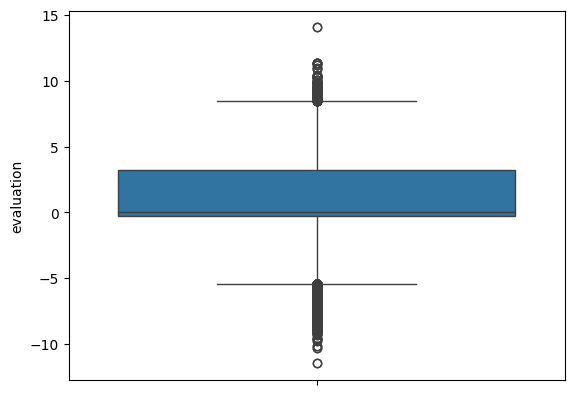

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

evaluations = df['evaluation']
sns.boxplot(evaluations)
plt.show()

In [96]:
print(evaluations.min(), evaluations.max())

-11.46 14.05
